# Task 4.3P - Build your own image recognition system – group task

In [2]:
import os
import shutil
import random

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import pickle

from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

from sklearn import svm

from yellowbrick.cluster import silhouette_visualizer, intercluster_distance, kelbow_visualizer

In [3]:
class Dictionary(object):
    def __init__(self, name, img_filenames, num_words):
        self.name = name #name of your dictionary
        self.img_filenames = img_filenames #list of image filenames
        self.num_words = num_words #the number of words
        self.training_data = [] #this is the training data required by the K-Means algorithm
        self.words = [] #list of words, which are the centroids of clusters
    
    def learn(self):
        sift = cv.SIFT_create()
        num_keypoints = [] #this is used to store the number of keypoints in each image
        #load training images and compute SIFT descriptors
        for filename in self.img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            list_des = sift.detectAndCompute(img_gray, None)[1]
            if list_des is None:
                num_keypoints.append(0)
            else:
                num_keypoints.append(len(list_des))
                for des in list_des:
                    self.training_data.append(des)
        #cluster SIFT descriptors using K-means algorithm
        kmeans = KMeans(self.num_words)
        kmeans.fit(self.training_data)
        self.words = kmeans.cluster_centers_
        #create word histograms for training images
        training_word_histograms = [] #list of word histograms of all training images
        index = 0
        for i in range(0, len(self.img_filenames)):
            #for each file, create a histogram
            histogram = np.zeros(self.num_words, np.float32)
            #if some keypoints exist
            if num_keypoints[i] > 0:
                for j in range(0, num_keypoints[i]):
                    histogram[kmeans.labels_[j + index]] += 1
                index += num_keypoints[i]
                histogram /= num_keypoints[i]
                training_word_histograms.append(histogram)
        return training_word_histograms

    def create_word_histograms(self, img_filenames):
        sift = cv.SIFT_create()
        histograms = []
        for filename in img_filenames:
            img = cv.imread(filename)
            img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
            descriptors = sift.detectAndCompute(img_gray, None)[1]
            histogram = np.zeros(self.num_words, np.float32) #word histogram for the input image
            if descriptors is not None:
                for des in descriptors:
                    #find the best matching word
                    min_distance = 1111111 #this can be any large number
                    matching_word_ID = -1 #initial matching_word_ID=-1 means no matching
                    for i in range(0, self.num_words): #search for the best matching word
                        distance = np.linalg.norm(des - self.words[i])
                        if distance < min_distance:
                            min_distance = distance
                            matching_word_ID = i
                    histogram[matching_word_ID] += 1
                histogram /= len(descriptors) #normalise histogram to frequencies
            histograms.append(histogram)
        return histograms

# 1. Data collection and annotation

In [4]:
# Define the image classes and the split ratios
classes = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
train_ratio = 0.4
val_ratio = 0.3
test_ratio = 0.3

# Create the output directories for each split
os.makedirs("images/train", exist_ok=True)
os.makedirs("images/val", exist_ok=True)
os.makedirs("images/test", exist_ok=True)

for cls in classes:
    # Get the list of image files for that class
    files = [file for file in os.listdir() if file.startswith(cls)]
    # Shuffle the files randomly with repeatable results using seed
    files = sorted(files)
    random.Random(42).shuffle(files)
    # Calculate the number of files for each split
    n_train = int(len(files) * train_ratio)
    n_val = int(len(files) * val_ratio)
    n_test = len(files) - n_train - n_val
    # Copy the files to the corresponding output directories
    for i, file in enumerate(files):
        src = file
        if i < n_train:
            dst = os.path.join("images/train", file)
        elif i < n_train + n_val:
            dst = os.path.join("images/val", file)
        else:
            dst = os.path.join("images/test", file)
        shutil.copy(src, dst)

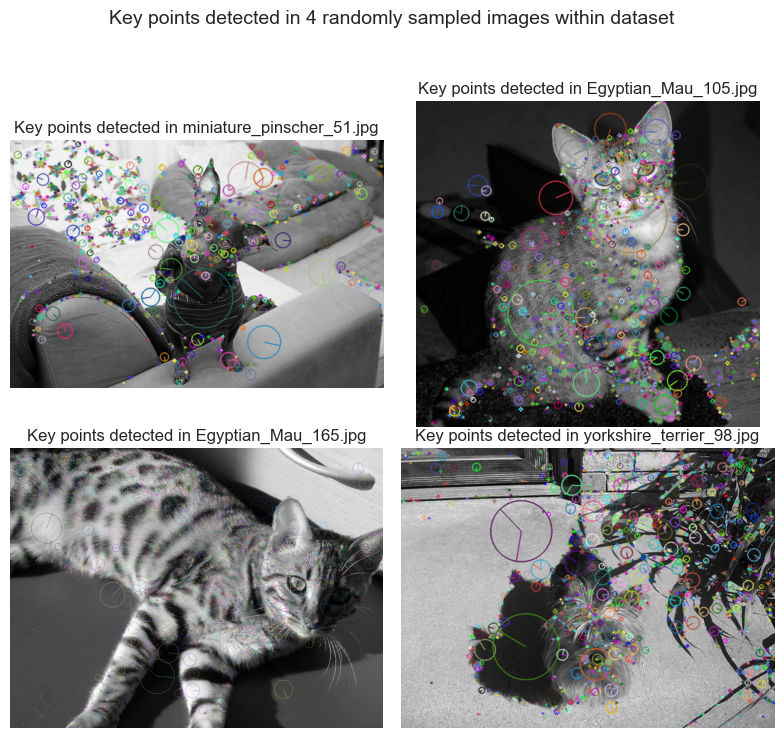

In [5]:
# Find key points of 4 random images and display to ensure that key points can be found
image_directory = './images/'
sift = cv.SIFT_create()
fig, imgs = plt.subplots(2,2)
fig.set_size_inches(8,8)

sampled_filenames = random.sample(os.listdir(image_directory), 4)
for idx, filename in enumerate(sampled_filenames):
    filepath = os.path.join(image_directory, filename)
    img = cv.imread(filepath) #load image
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp = sift.detect(img_gray, None)
    img_gray_kp = img_gray.copy()
    img_gray_kp = cv.drawKeypoints(img_gray, kp, img_gray_kp, flags = cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    index = np.unravel_index(idx,(2,2))
    imgs[index].imshow(img_gray_kp)
    imgs[index].axis('off')
    imgs[index].set_title(f"Key points detected in {filename}")


fig.suptitle("Key points detected in 4 randomly sampled images within dataset", fontsize=14)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Labelling training, validation and testing data

In [6]:
breeds = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
path = 'images/'
training_file_names = []
training_breed_labels = []
validation_file_names = []
validation_breed_labels = []
testing_file_names = []
testing_breed_labels = []
for i, breed in enumerate(breeds):
    # Training Data
    sub_path = path + 'train/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_breed_labels += sub_breed_labels
    # Validation Data
    sub_path = path + 'val/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    validation_file_names += sub_file_names
    validation_breed_labels += sub_breed_labels
    # Testing Data
    sub_path = path + 'test/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    testing_file_names += sub_file_names
    testing_breed_labels += sub_breed_labels

print(training_file_names)
print(training_breed_labels)

print(validation_file_names)
print(validation_breed_labels)

print(testing_file_names)
print(testing_breed_labels)

['images/train/shiba_inu_57.jpg', 'images/train/shiba_inu_80.jpg', 'images/train/shiba_inu_94.jpg', 'images/train/shiba_inu_95.jpg', 'images/train/shiba_inu_137.jpg', 'images/train/shiba_inu_68.jpg', 'images/train/shiba_inu_40.jpg', 'images/train/shiba_inu_96.jpg', 'images/train/shiba_inu_41.jpg', 'images/train/shiba_inu_108.jpg', 'images/train/shiba_inu_79.jpg', 'images/train/shiba_inu_92.jpg', 'images/train/shiba_inu_87.jpg', 'images/train/shiba_inu_93.jpg', 'images/train/shiba_inu_78.jpg', 'images/train/shiba_inu_131.jpg', 'images/train/shiba_inu_50.jpg', 'images/train/shiba_inu_133.jpg', 'images/train/shiba_inu_132.jpg', 'images/train/shiba_inu_126.jpg', 'images/train/shiba_inu_141.jpg', 'images/train/shiba_inu_20.jpg', 'images/train/shiba_inu_34.jpg', 'images/train/shiba_inu_140.jpg', 'images/train/shiba_inu_142.jpg', 'images/train/shiba_inu_181.jpg', 'images/train/shiba_inu_208.jpg', 'images/train/shiba_inu_209.jpg', 'images/train/shiba_inu_1.jpg', 'images/train/shiba_inu_22.jpg'

In [ ]:
sift = cv.SIFT_create()
num_keypoints = [] #this is used to store the number of keypoints in each image
training_data = []
#load training images and compute SIFT descriptors
for filename in training_file_names:
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    list_des = sift.detectAndCompute(img_gray, None)[1]
    if list_des is None:
        num_keypoints.append(0)
    else:
        num_keypoints.append(len(list_des))
        for des in list_des:
            training_data.append(des)

training_data = np.array(training_data)

# 2. Building image recognition application

## 2.1. Building BoW model (Silhouette analysis)

In [ ]:
sift = cv.SIFT_create()
num_keypoints = [] #this is used to store the number of keypoints in each image
training_data = []
#load training images and compute SIFT descriptors
for filename in training_file_names:
    img = cv.imread(filename)
    img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    list_des = sift.detectAndCompute(img_gray, None)[1]
    if list_des is None:
        num_keypoints.append(0)
    else:
        num_keypoints.append(len(list_des))
        for des in list_des:
            training_data.append(des)

training_data = np.array(training_data)

Training kMeans model with 25 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


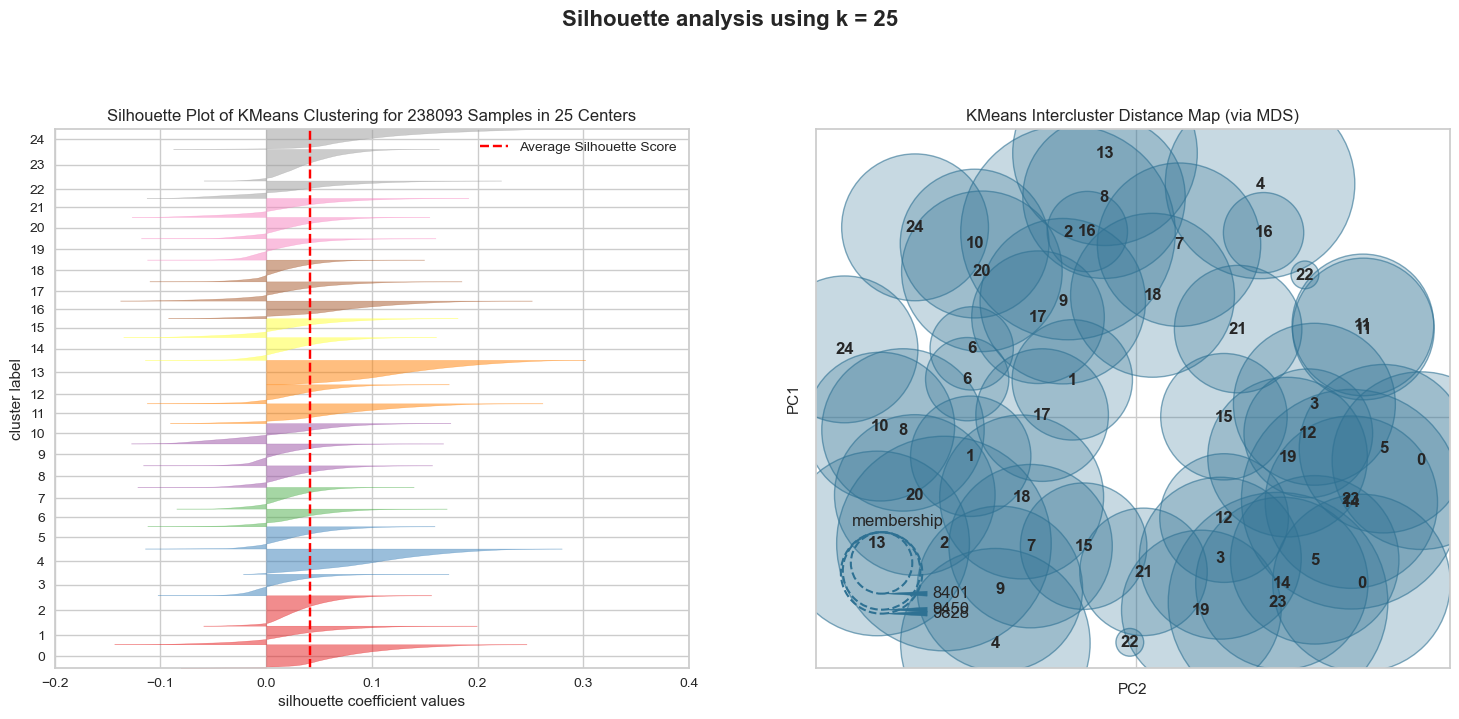

Training kMeans model with 50 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


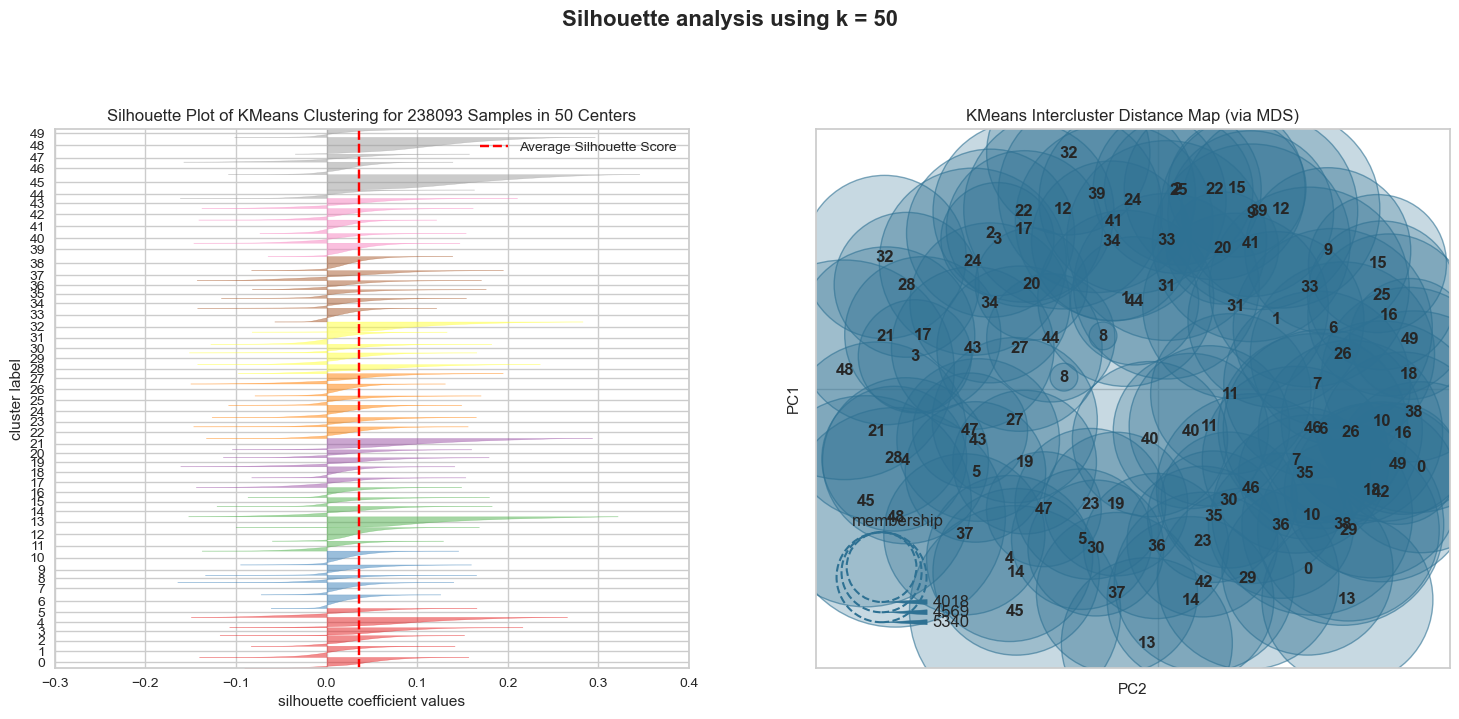

Training kMeans model with 100 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


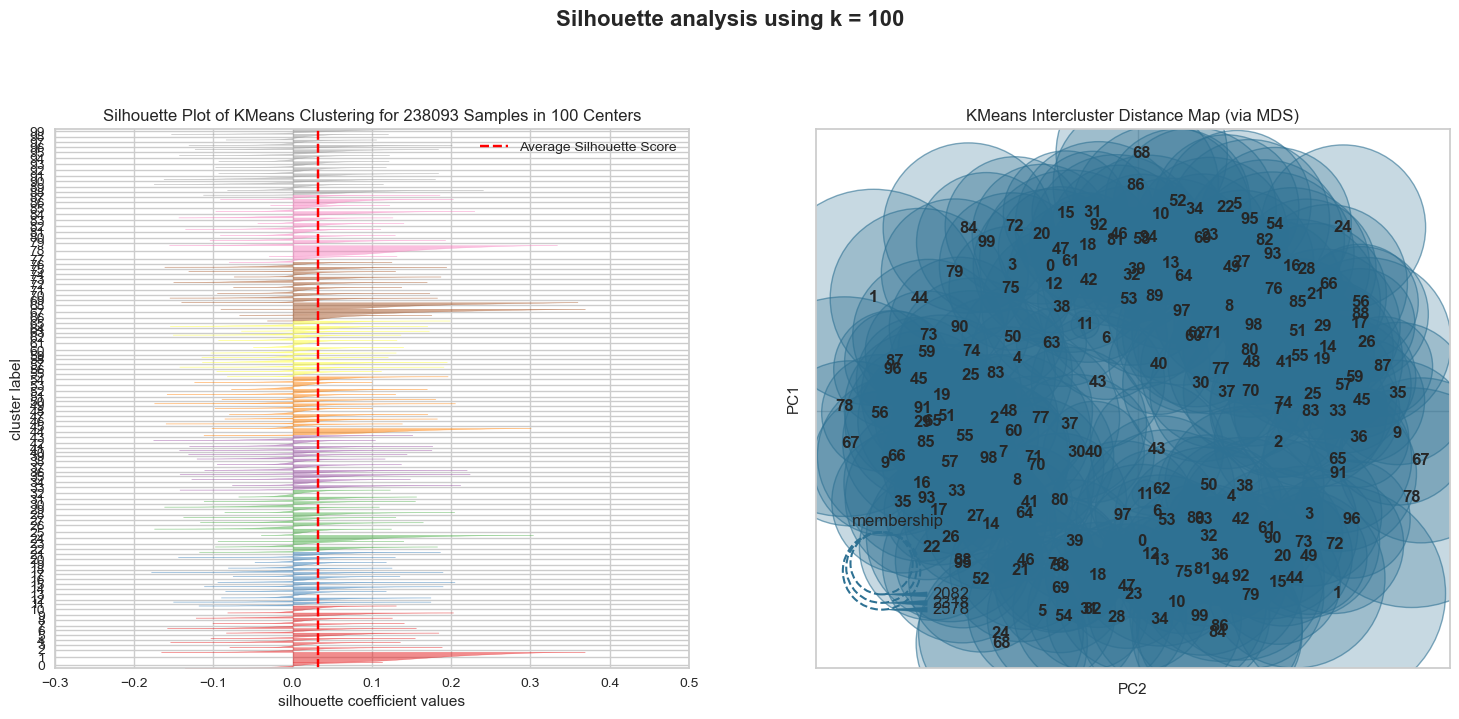

Training kMeans model with 200 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


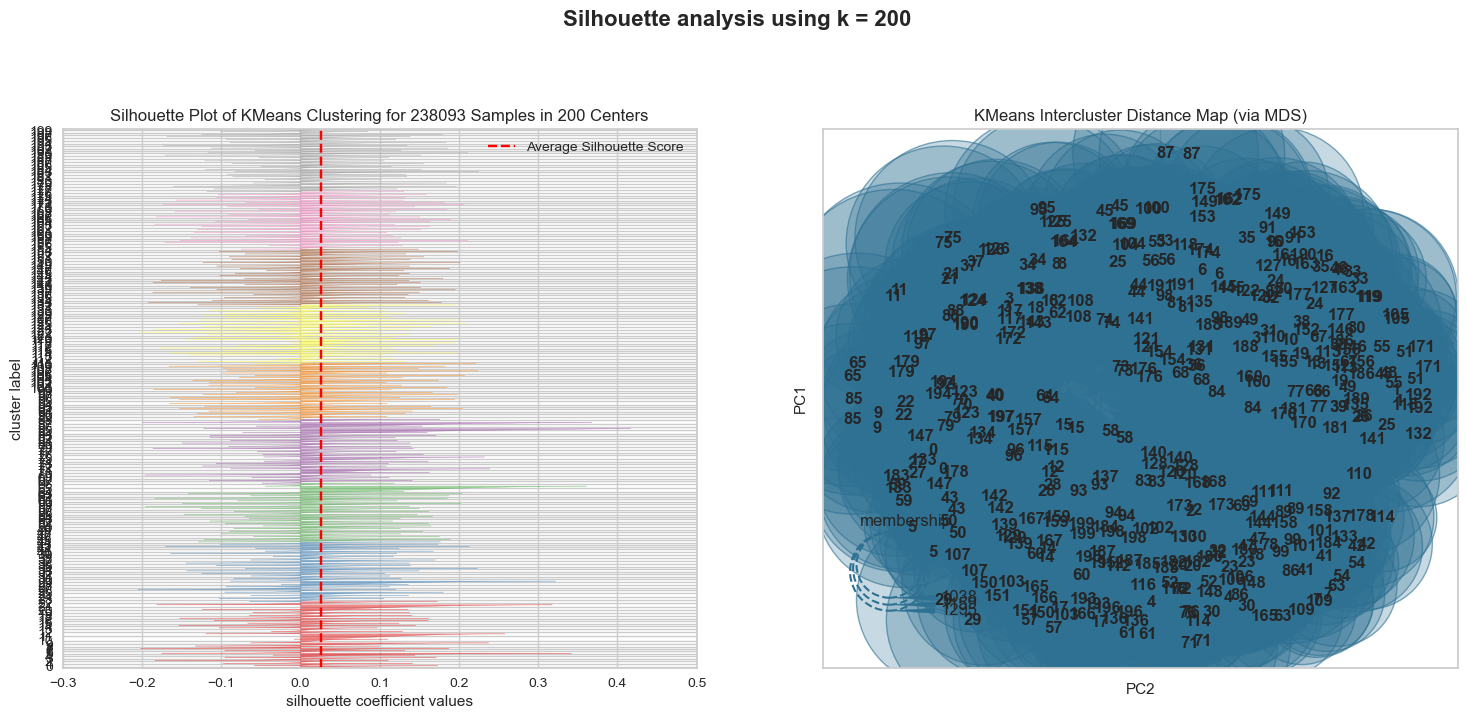

Training kMeans model with 500 clusters...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Generating silhouette plot...
Generating intercluster distance plot...


/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


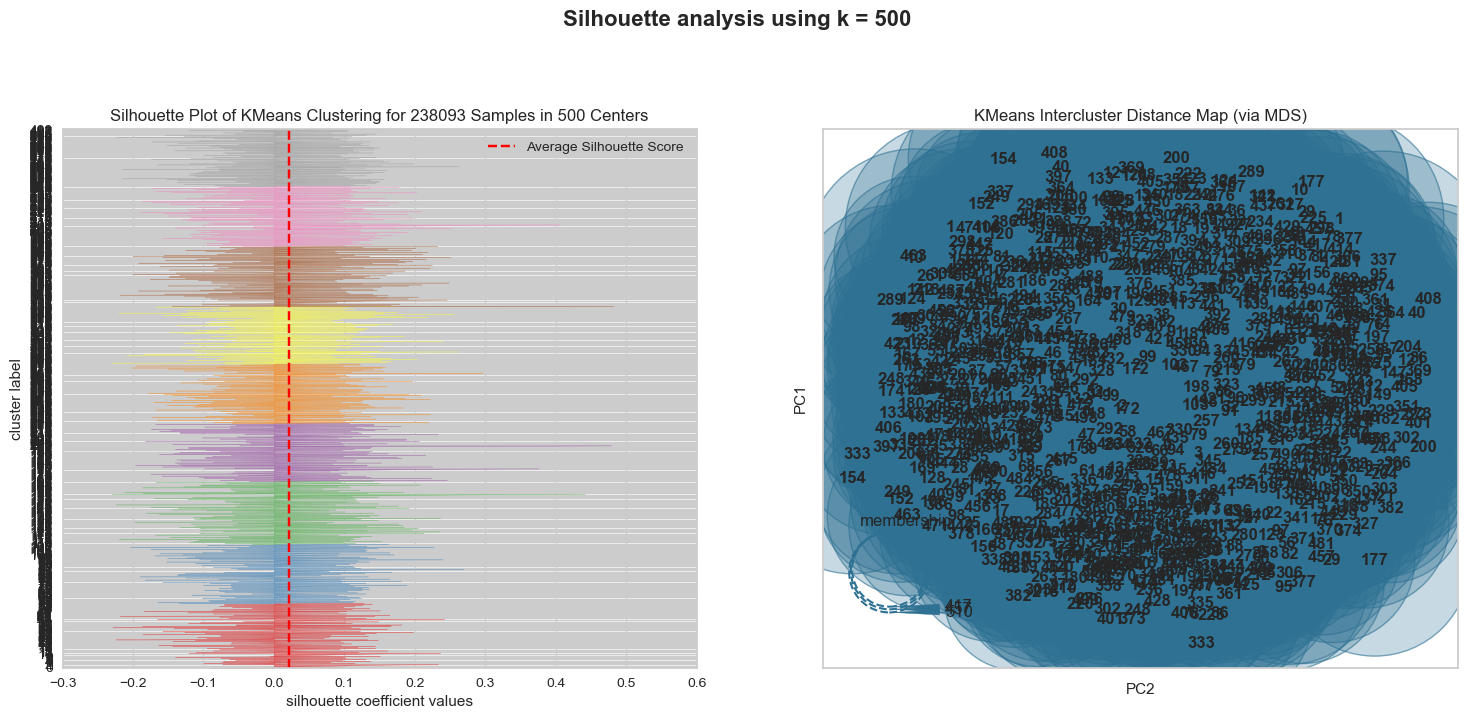

In [ ]:
for i, k in enumerate([25,50,100,200,500]):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    
    # Run the Kmeans algorithm
    km = KMeans(n_clusters=k)
    print(f"Training kMeans model with {k} clusters...")
    labels = km.fit_predict(training_data)
    
    # Silhouette plot
    print("Generating silhouette plot...")
    silhouette_vis = silhouette_visualizer(km, training_data, ax=ax1, is_fitted=True, show=False)
    
    # Scatter plot of data colored with labels
    print("Generating intercluster distance plot...")
    scatter_vis = intercluster_distance(km, training_data, ax=ax2, is_fitted=True, show=False)
    scatter_vis.fit(training_data)

    plt.suptitle(f'Silhouette analysis using k = {k}',
                 fontsize=16, fontweight='semibold', y=1.05)
    plt.show()

/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Se

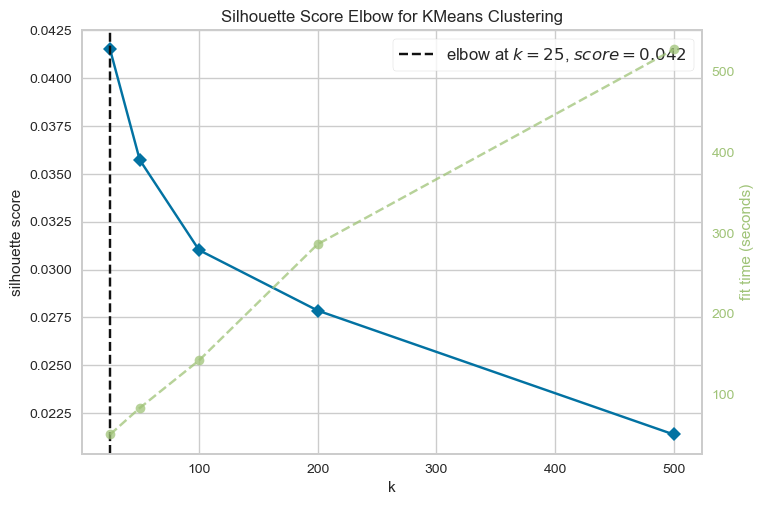

KElbowVisualizer(ax=<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>,
                 estimator=KMeans(n_clusters=500), k=[25, 50, 100, 200, 500],
                 metric='silhouette')

In [ ]:
kelbow_visualizer(KMeans(), training_data, k=[25,50,100,200,500], metric="silhouette")

## 2.1. Building BoW model

Generating kelbow plot...


c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\clust

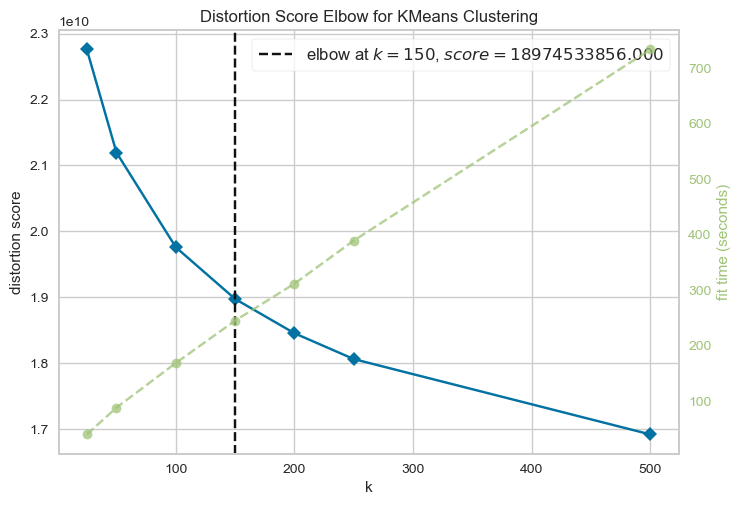

c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nsrih\anaconda3\Lib\site-packages\sklearn\clust

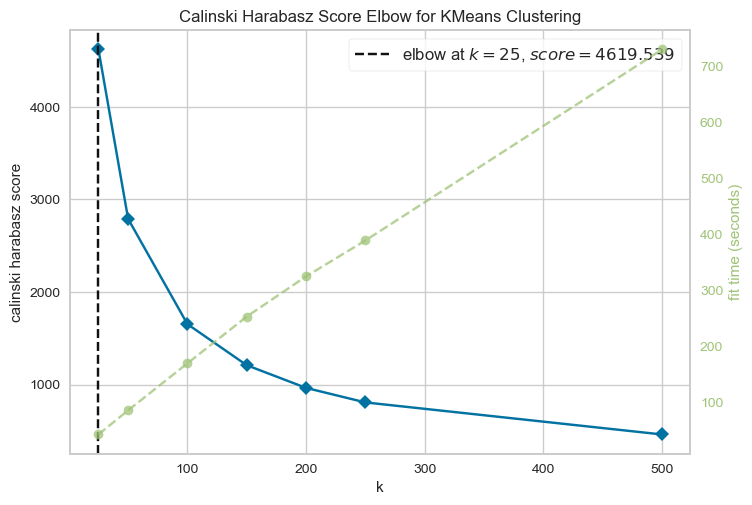

In [ ]:
# Kelbow distortion plot
print("Generating kelbow plot...")
kelbow_vis_distortion = kelbow_visualizer(KMeans(), training_data, k=[25,50,100,150,200,250,500], metric="distortion")

# Kelbow calinski_harabasz plot
kelbow_vis_calinski = kelbow_visualizer(KMeans(), training_data, k=[25,50,100,150,200,250,500], metric="calinski_harabasz")

In [7]:
# Pick number of words as 50 from above analysis
num_words = 50
dictionary_name = 'breeds'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)

In [8]:
training_word_histograms = dictionary.learn()
validation_word_histograms = dictionary.create_word_histograms(validation_file_names)
testing_word_histograms = dictionary.create_word_histograms(testing_file_names)

/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


In [9]:
# Save Dictionary
with open('breeds_dictionary.dic', 'wb') as f: #'wb' is for binary write
    pickle.dump(dictionary, f)

In [10]:
# Read Dictionary
with open('breeds_dictionary.dic', 'rb') as f: #'rb' is for binary read
    dictionary = pickle.load(f)

## 2.2 Building classifiers

### SVM

#### Training SVM with varying values of C

In [11]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
C = [0.1, 1, 10, 20, 30, 40, 50, 100]

In [12]:
for c in C:
    # SVM classifier
    svm_classifier = svm.SVC(C = c, kernel = 'linear')
    svm_classifier.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on training dataset
    training_pred = svm_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on validation dataset
    validation_pred = svm_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

    # Get accuracy on testing dataset
    testing_pred = svm_classifier.predict(testing_word_histograms)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred)
    testing_accuracies.append(testing_acc)

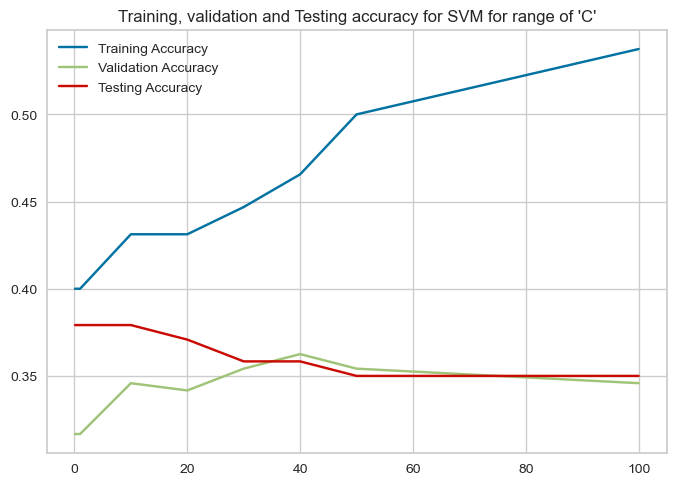

In [13]:
# Plot the results
plt.plot(C, training_accuracies, label='Training Accuracy')
plt.plot(C, validation_accuracies, label='Validation Accuracy')
plt.plot(C, testing_accuracies, label='Testing Accuracy')
plt.legend()
plt.title("Training, validation and Testing accuracy for SVM for range of 'C'")
plt.show()

In [14]:
for c, validation_accuracy in zip(C, validation_accuracies):
    print("Prediction accuracy of SVM model on validation dataset when C = %s is %s" % (c, validation_accuracy))

Prediction accuracy of SVM model on validation dataset when C = 0.1 is 0.31666666666666665
Prediction accuracy of SVM model on validation dataset when C = 1 is 0.31666666666666665
Prediction accuracy of SVM model on validation dataset when C = 10 is 0.3458333333333333
Prediction accuracy of SVM model on validation dataset when C = 20 is 0.3416666666666667
Prediction accuracy of SVM model on validation dataset when C = 30 is 0.3541666666666667
Prediction accuracy of SVM model on validation dataset when C = 40 is 0.3625
Prediction accuracy of SVM model on validation dataset when C = 50 is 0.3541666666666667
Prediction accuracy of SVM model on validation dataset when C = 100 is 0.3458333333333333


#### Training SVM with the best C hyperparameter

In [15]:
best_c = C[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The best C for SVM model is {best_c} with a validation accuracy of {best_val_acc:.2%}")

The best C for SVM model is 40 with a validation accuracy of 36.25%


In [16]:
svm_classifier = svm.SVC(C = best_c, kernel = 'linear')
svm_classifier.fit(training_word_histograms, training_breed_labels)

SVC(C=40, kernel='linear')

### Adaboost

#### Training Adaboost with varying values of n_estimator

In [17]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
n_estimator_range = [50, 100, 150, 200, 250]

In [18]:
for n_estimator in n_estimator_range:
    # Adaboost classifier
    adb_classifier = AdaBoostClassifier(n_estimators = n_estimator, random_state = 0)
    adb_classifier.fit(training_word_histograms, training_breed_labels)
    
    # Get accuracy on training dataset
    training_pred = adb_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on validation dataset
    validation_pred = adb_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

    # Get accuracy on testing dataset
    testing_pred = adb_classifier.predict(testing_word_histograms)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred)
    testing_accuracies.append(testing_acc)

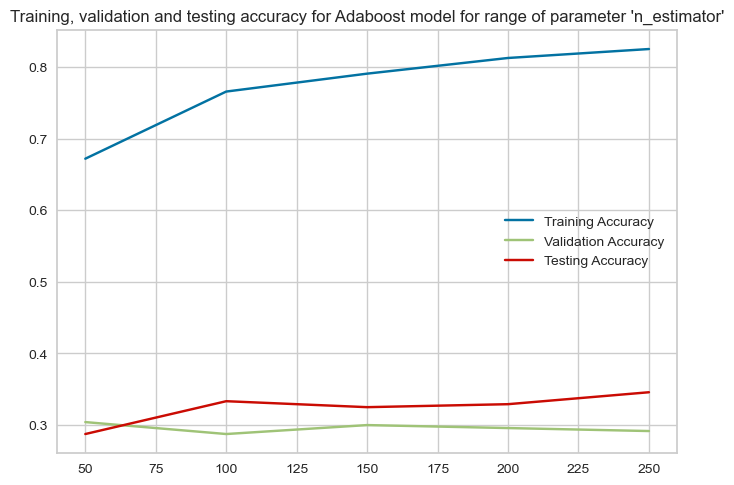

In [19]:
# Plot the results
plt.plot(n_estimator_range, training_accuracies, label='Training Accuracy')
plt.plot(n_estimator_range, validation_accuracies, label='Validation Accuracy')
plt.plot(n_estimator_range, testing_accuracies, label='Testing Accuracy')
plt.legend()
plt.title("Training, validation and testing accuracy for Adaboost model for range of parameter 'n_estimator'")
plt.show()

In [20]:
for n_estimator, validation_accuracy in zip(n_estimator_range, validation_accuracies):
    print("Prediction accuracy of Adaboost model on validation dataset when n_estimators = %s is %s" % (n_estimator, validation_accuracy))

Prediction accuracy of Adaboost model on validation dataset when n_estimators = 50 is 0.30416666666666664
Prediction accuracy of Adaboost model on validation dataset when n_estimators = 100 is 0.2875
Prediction accuracy of Adaboost model on validation dataset when n_estimators = 150 is 0.3
Prediction accuracy of Adaboost model on validation dataset when n_estimators = 200 is 0.29583333333333334
Prediction accuracy of Adaboost model on validation dataset when n_estimators = 250 is 0.2916666666666667


#### Training Adaboost with best n_estimator

In [21]:
best_n = n_estimator_range[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The best value of N-estimator for Adaboost model is {best_n} with an accuracy of {best_val_acc:.2%}")

The best value of N-estimator for Adaboost model is 50 with an accuracy of 30.42%


In [22]:
# Training on best parameters
adb_classifier = AdaBoostClassifier(n_estimators = best_n, random_state = 0)
adb_classifier.fit(training_word_histograms, training_breed_labels)

AdaBoostClassifier(random_state=0)

### K-NN

#### Training KNN with varying values of k

In [23]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
nn_search_space = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

In [24]:
# Train the knn model

for n_neighbours in nn_search_space:
    knn = KNeighborsClassifier(n_neighbors = n_neighbours)
    knn.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on training dataset
    training_pred = knn.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)
    
    # Get accuracy on validation dataset
    validation_pred = knn.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

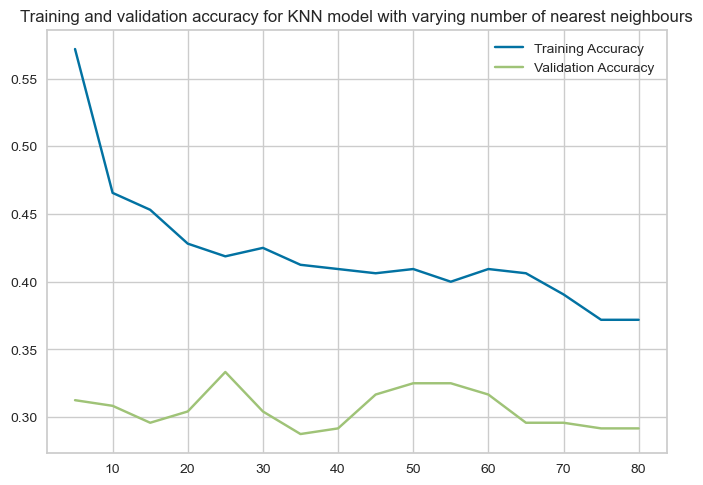

In [25]:
# Plot the results

plt.plot(nn_search_space, training_accuracies, label='Training Accuracy')
plt.plot(nn_search_space, validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Training and validation accuracy for KNN model with varying number of nearest neighbours")
plt.show()

#### Training KNN with the best K hyperparameter

In [26]:
best_nn = nn_search_space[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The value for number of nearest neighbour with the best validation accuracy is {best_nn} with an accuracy of {best_val_acc:.2%}")

The value for number of nearest neighbour with the best validation accuracy is 25 with an accuracy of 33.33%


In [27]:
# Re-train and save best model
knn = KNeighborsClassifier(n_neighbors = best_nn)
knn.fit(training_word_histograms, training_breed_labels)
with open('best_knn.pkl', 'wb') as f: #'wb' is for binary write
    pickle.dump(knn, f)

### Random Forest

#### Training Random Forest with varying values of number of estimators

In [28]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
n_estimators_search_space = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [29]:
# Train the rf model

for n_estimators in n_estimators_search_space:
    rf = RandomForestClassifier(n_estimators= n_neighbours)
    rf.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on training dataset
    training_pred = rf.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)
    
    # Get accuracy on validation dataset
    validation_pred = rf.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

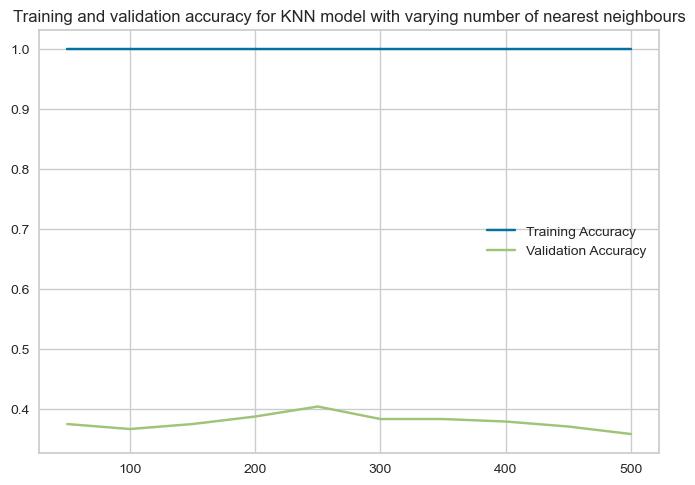

In [30]:
# Plot the results

plt.plot(n_estimators_search_space, training_accuracies, label='Training Accuracy')
plt.plot(n_estimators_search_space, validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Training and validation accuracy for KNN model with varying number of nearest neighbours")
plt.show()

#### Training SVM with best number of estimators hyperparameter

In [31]:
best_n_estimators = n_estimators_search_space[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The value for number of estimators with the best validation accuracy is {best_n_estimators} with an accuracy of {best_val_acc:.2%}")

The value for number of estimators with the best validation accuracy is 250 with an accuracy of 40.42%


In [32]:
# Re-train and save best model
rf = RandomForestClassifier(n_estimators= best_n_estimators)
rf.fit(training_word_histograms, training_breed_labels)
with open('best_rf.pkl', 'wb') as f: #'wb' is for binary write
    pickle.dump(rf, f)

## 2.3 Evaluating classifiers

### SVM

In [33]:
predicted_breed_labels = svm_classifier.predict(validation_word_histograms)
print('Breed label: ', predicted_breed_labels)

Breed label:  [2 1 2 2 0 2 2 2 0 2 2 2 2 0 2 2 0 1 3 3 2 2 1 0 2 0 2 3 0 3 2 3 2 0 2 2 2
 2 2 2 2 2 1 0 2 2 0 2 2 1 1 3 2 2 0 2 2 2 2 3 0 2 2 2 1 2 1 1 2 2 1 2 1 2
 1 2 3 0 2 2 2 1 0 2 0 0 0 0 2 1 2 3 1 1 1 1 3 0 2 2 1 2 3 2 1 1 1 1 0 2 2
 3 2 1 1 1 0 1 2 1 0 1 2 2 0 2 2 2 2 2 2 2 2 2 2 1 1 2 2 1 2 2 2 1 3 1 2 1
 1 2 2 0 2 2 2 2 2 2 1 3 2 2 2 3 1 1 3 2 1 1 2 1 1 2 1 1 2 2 2 2 2 3 1 0 3
 2 3 3 2 1 2 3 2 3 2 1 0 2 0 2 2 3 2 0 2 2 3 1 3 3 1 0 2 3 2 2 2 3 3 2 2 2
 1 3 3 0 2 3 1 2 3 1 2 2 0 0 0 3 2 2]


The best value of C is 30 for testing data with an accuracy of 40.42%


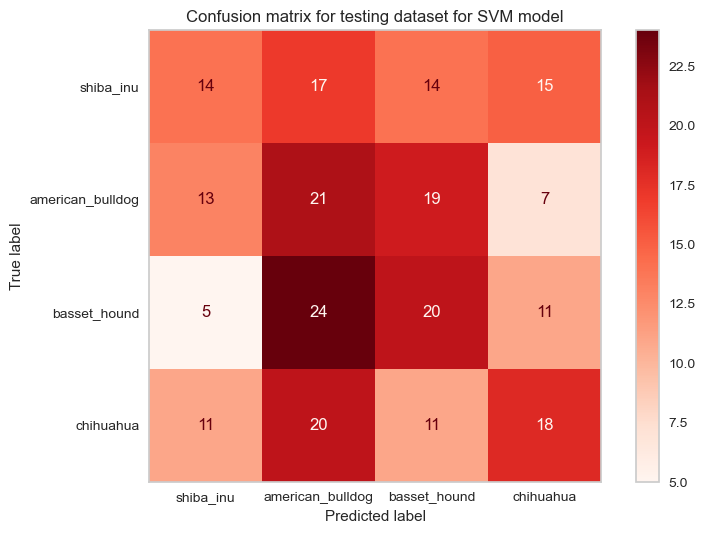

In [42]:
# best C for testing data
best_c = C[np.argmax(testing_accuracies)]
best_test_acc = max(testing_accuracies)
print(f"The best value of C is {best_c} for testing data with an accuracy of {best_val_acc:.2%}")
# C = best_c SVM classification
svm_classifier = svm.SVC(C = best_c, kernel = 'linear')
svm_classifier.fit(training_word_histograms, training_breed_labels)
# Testing on test data using best C hyperparameter
svm_predicted_labels = svm_classifier.predict(testing_word_histograms)
# Generating a confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Reds) # use a blue color map
plt.title('Confusion matrix for testing dataset for SVM model')
plt.tight_layout()
plt.grid(False)
plt.show()

### Adaboost

In [35]:
predicted_breed_labels = adb_classifier.predict(validation_word_histograms)
print('Breed label: ', predicted_breed_labels)

Breed label:  [1 2 2 2 0 3 1 0 0 1 2 1 1 3 1 2 3 1 3 3 2 0 0 0 1 1 0 2 1 0 2 3 3 3 3 0 3
 2 0 0 1 2 1 3 2 1 3 2 3 2 1 0 1 3 3 1 2 0 1 0 0 1 0 1 1 2 3 3 1 2 0 1 0 1
 0 2 0 3 2 1 1 0 0 0 3 0 2 2 1 1 3 2 1 1 1 1 3 3 2 2 1 2 0 1 2 1 2 2 1 2 2
 0 2 1 1 0 1 2 2 2 0 3 0 2 0 2 1 1 1 3 1 2 2 3 2 3 1 3 2 2 1 3 2 3 3 1 1 1
 2 2 3 0 2 2 0 2 1 1 1 2 2 1 1 3 1 1 2 2 1 1 2 1 1 1 2 1 3 1 1 2 3 1 1 3 3
 2 1 1 1 1 1 3 2 3 2 1 2 1 3 1 2 0 3 1 0 2 3 0 0 3 1 0 3 3 3 0 2 1 0 2 1 3
 1 3 0 2 1 3 1 1 3 1 3 0 1 0 0 3 2 2]


The best value of n-estimators is 250 for testing data with an accuracy of 40.42%


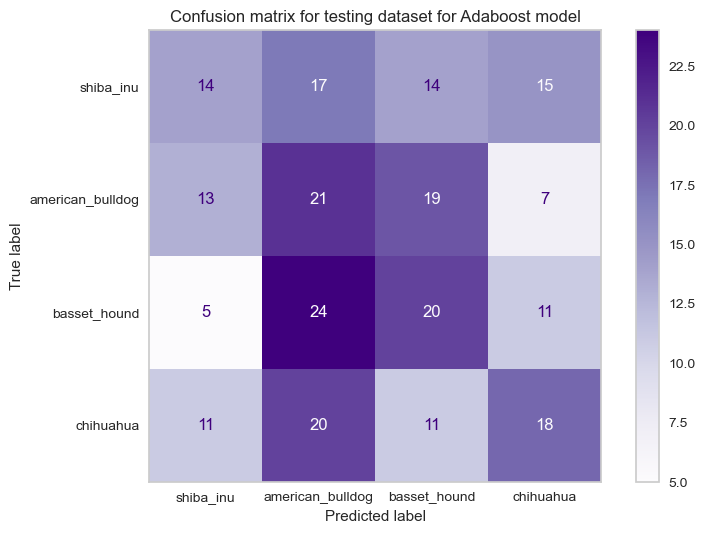

In [43]:
best_n = n_estimator_range[np.argmax(testing_accuracies)]
best_test_acc = max(testing_accuracies)
print(f"The best value of n-estimators is {best_n} for testing data with an accuracy of {best_val_acc:.2%}")
# Training on best parameters
adb_classifier = AdaBoostClassifier(n_estimators = best_n, random_state = 0)
adb_classifier.fit(training_word_histograms, training_breed_labels)
# Testing on best parameters using Test data
adb_predicted_labels = adb_classifier.predict(testing_word_histograms)
# Confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Purples) # use a blue color map
plt.title('Confusion matrix for testing dataset for Adaboost model')
plt.tight_layout()
plt.grid(False)
plt.show()

#### KNN

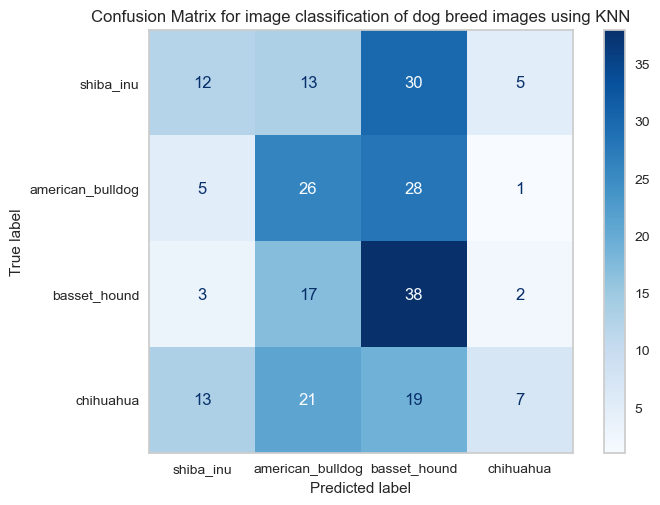

In [37]:
knn_predicted_labels = knn.predict(testing_word_histograms)

# Plot confusion matrices
knn_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, knn_predicted_labels, display_labels=breeds, cmap="Blues")
knn_cf_disp.ax_.set_title("Confusion Matrix for image classification of dog breed images using KNN")
plt.grid(False)
plt.show()

### Random Forest

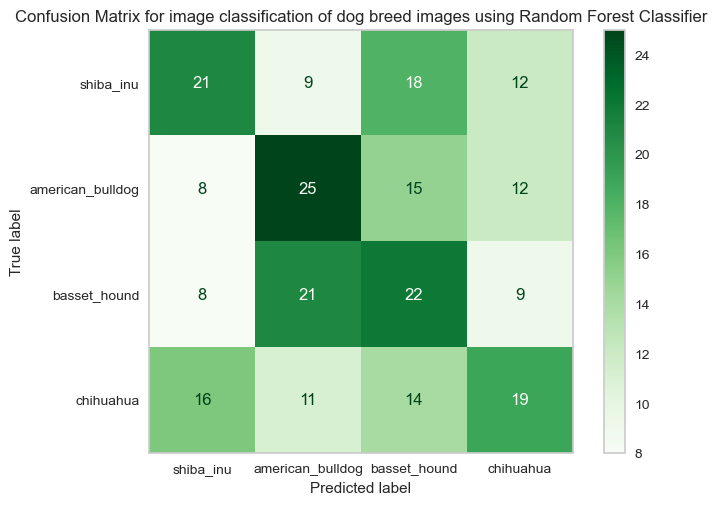

In [38]:
rf_predicted_labels = rf.predict(testing_word_histograms)

rf_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, rf_predicted_labels, display_labels=breeds, cmap="Greens")
rf_cf_disp.ax_.set_title("Confusion Matrix for image classification of dog breed images using Random Forest Classifier")
plt.grid(False)
plt.show()

### Comparison

The testing accuracy for the KNN model is 35.83%
The testing accuracy for the Random Forest model is 34.58%
The testing accuracy for the KNN model is 34.58%
The testing accuracy for the Random Forest model is 36.25%


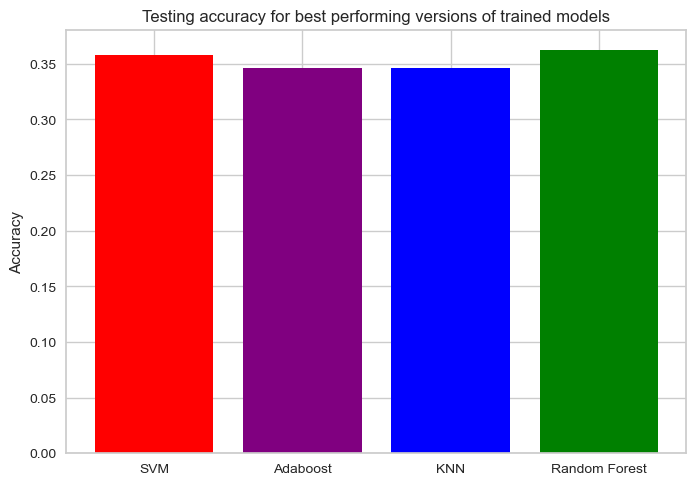

In [41]:
svm_test_acc = accuracy_score(testing_breed_labels, svm_predicted_labels)
print(f"The testing accuracy for the KNN model is {svm_test_acc:.2%}")
adb_test_acc = accuracy_score(testing_breed_labels, adb_predicted_labels)
print(f"The testing accuracy for the Random Forest model is {adb_test_acc:.2%}")
knn_test_acc = accuracy_score(testing_breed_labels, knn_predicted_labels)
print(f"The testing accuracy for the KNN model is {knn_test_acc:.2%}")
rf_test_acc = accuracy_score(testing_breed_labels, rf_predicted_labels)
print(f"The testing accuracy for the Random Forest model is {rf_test_acc:.2%}")

# Plot results
plt.bar(['SVM','Adaboost','KNN', 'Random Forest'], [svm_test_acc, adb_test_acc, knn_test_acc, rf_test_acc], color=['red','purple','blue','green'])
plt.ylabel('Accuracy')
plt.title('Testing accuracy for best performing versions of trained models')
plt.show()

# 2.2 Building classifiers after removing background

In [44]:
# Make output directories
os.makedirs("images/filtered_train", exist_ok=True)
os.makedirs("images/filtered_val", exist_ok=True)
os.makedirs("images/filtered_test", exist_ok=True)

# Get the list of files in the images folder
files = os.listdir("images/train/")

for file in files:
    # Check if the file is an image
    if file.endswith(".jpg"):
        # Load the image and the trimap as grayscale images
        image = cv.imread("images/train/" + file)
        trimap = cv.imread("annotations/trimaps/" + file[:-4] + ".png", cv.IMREAD_GRAYSCALE)

        mask = np.zeros(trimap.shape, np.uint8)
        mask[trimap == 2] = cv.GC_BGD # background
        mask[trimap == 1] = cv.GC_FGD # foreground
        mask[trimap == 0] = cv.GC_PR_FGD # probably foreground

        # Create a binary mask for the foreground and background regions
        fg_mask = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 255, 0).astype(np.uint8)
        bg_mask = np.where((mask == cv.GC_BGD) | (mask == cv.GC_PR_BGD), 255, 0).astype(np.uint8)

        # Apply bitwise operations to extract the foreground and background pixels from the image using the mask
        fg = cv.bitwise_and(image, image, mask=fg_mask)
        bg = cv.bitwise_and(image, image, mask=bg_mask)

        # write the results
        cv.imwrite("images/filtered_train/" + file, fg)

# Get the list of files in the images folder
files = os.listdir("images/val/")

for file in files:
    # Check if the file is an image
    if file.endswith(".jpg"):
        # Load the image and the trimap as grayscale images
        image = cv.imread("images/val/" + file)
        trimap = cv.imread("annotations/trimaps/" + file[:-4] + ".png", cv.IMREAD_GRAYSCALE)

        mask = np.zeros(trimap.shape, np.uint8)
        mask[trimap == 2] = cv.GC_BGD # background
        mask[trimap == 1] = cv.GC_FGD # foreground
        mask[trimap == 0] = cv.GC_PR_FGD # probably foreground

        # Create a binary mask for the foreground and background regions
        fg_mask = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 255, 0).astype(np.uint8)
        bg_mask = np.where((mask == cv.GC_BGD) | (mask == cv.GC_PR_BGD), 255, 0).astype(np.uint8)

        # Apply bitwise operations to extract the foreground and background pixels from the image using the mask
        fg = cv.bitwise_and(image, image, mask=fg_mask)
        bg = cv.bitwise_and(image, image, mask=bg_mask)

        # write the results
        cv.imwrite("images/filtered_val/" + file, fg)

# Get the list of files in the images folder
files = os.listdir("images/test/")

for file in files:
    # Check if the file is an image
    if file.endswith(".jpg"):
        # Load the image and the trimap as grayscale images
        image = cv.imread("images/test/" + file)
        trimap = cv.imread("annotations/trimaps/" + file[:-4] + ".png", cv.IMREAD_GRAYSCALE)

        mask = np.zeros(trimap.shape, np.uint8)
        mask[trimap == 2] = cv.GC_BGD # background
        mask[trimap == 1] = cv.GC_FGD # foreground
        mask[trimap == 0] = cv.GC_PR_FGD # probably foreground

        # Create a binary mask for the foreground and background regions
        fg_mask = np.where((mask == cv.GC_FGD) | (mask == cv.GC_PR_FGD), 255, 0).astype(np.uint8)
        bg_mask = np.where((mask == cv.GC_BGD) | (mask == cv.GC_PR_BGD), 255, 0).astype(np.uint8)

        # Apply bitwise operations to extract the foreground and background pixels from the image using the mask
        fg = cv.bitwise_and(image, image, mask=fg_mask)
        bg = cv.bitwise_and(image, image, mask=bg_mask)

        # write the results
        cv.imwrite("images/filtered_test/" + file, fg)

Corrupt JPEG data: 240 extraneous bytes before marker 0xd9


### Labelling training, validation and testing data after background removal

In [48]:
breeds = ["shiba_inu", "american_bulldog", "basset_hound", "chihuahua"]
path = 'images/'
training_file_names = []
training_breed_labels = []
validation_file_names = []
validation_breed_labels = []
testing_file_names = []
testing_breed_labels = []
testing_file_names_bg_removed = []
for i, breed in enumerate(breeds):
    # Training Data
    sub_path = path + 'filtered_train/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    training_file_names += sub_file_names
    training_breed_labels += sub_breed_labels
    # Validation Data
    sub_path = path + 'filtered_val/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    validation_file_names += sub_file_names
    validation_breed_labels += sub_breed_labels
    # Testing Data
    sub_path = path + 'test/'
    sub_path_bg_rm = path + 'filtered_test/'
    sub_file_names = [os.path.join(sub_path, file) for file in os.listdir(sub_path) if file.startswith(breed)]
    sub_file_names_bg_rm = [os.path.join(sub_path_bg_rm, file) for file in os.listdir(sub_path_bg_rm) if file.startswith(breed)]
    sub_breed_labels = [i] * len(sub_file_names) #create a list of N elements, all are i
    testing_file_names += sub_file_names
    testing_breed_labels += sub_breed_labels
    testing_file_names_bg_removed += sub_file_names_bg_rm

print(training_file_names)
print(training_breed_labels)

print(validation_file_names)
print(validation_breed_labels)

print(testing_file_names)
print(testing_breed_labels)

['images/filtered_train/shiba_inu_57.jpg', 'images/filtered_train/shiba_inu_80.jpg', 'images/filtered_train/shiba_inu_94.jpg', 'images/filtered_train/shiba_inu_95.jpg', 'images/filtered_train/shiba_inu_137.jpg', 'images/filtered_train/shiba_inu_68.jpg', 'images/filtered_train/shiba_inu_40.jpg', 'images/filtered_train/shiba_inu_96.jpg', 'images/filtered_train/shiba_inu_41.jpg', 'images/filtered_train/shiba_inu_108.jpg', 'images/filtered_train/shiba_inu_79.jpg', 'images/filtered_train/shiba_inu_92.jpg', 'images/filtered_train/shiba_inu_87.jpg', 'images/filtered_train/shiba_inu_93.jpg', 'images/filtered_train/shiba_inu_78.jpg', 'images/filtered_train/shiba_inu_131.jpg', 'images/filtered_train/shiba_inu_50.jpg', 'images/filtered_train/shiba_inu_133.jpg', 'images/filtered_train/shiba_inu_132.jpg', 'images/filtered_train/shiba_inu_126.jpg', 'images/filtered_train/shiba_inu_141.jpg', 'images/filtered_train/shiba_inu_20.jpg', 'images/filtered_train/shiba_inu_34.jpg', 'images/filtered_train/shi

In [50]:
num_words = 50
dictionary_name = 'breeds'
dictionary = Dictionary(dictionary_name, training_file_names, num_words)

In [51]:
training_word_histograms = dictionary.learn()
validation_word_histograms = dictionary.create_word_histograms(validation_file_names)
testing_word_histograms = dictionary.create_word_histograms(testing_file_names)
testing_word_histograms_bg_rm = dictionary.create_word_histograms(testing_file_names_bg_removed)

/Users/brenton/miniconda3/envs/SIT789-Task4-3P/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


### SVM

In [52]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
testing_accuracies_bg_rm = []
C = [0.1, 1, 10, 20, 30, 40, 50, 100]

In [53]:
for c in C:
    # SVM classifier
    svm_classifier = svm.SVC(C = c, kernel = 'linear')
    svm_classifier.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on background removed training dataset
    training_pred = svm_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on background removed validation dataset
    validation_pred = svm_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

    # Get accuracy on normal testing dataset
    testing_pred = svm_classifier.predict(testing_word_histograms)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred)
    testing_accuracies.append(testing_acc)

    # Get accuracy on background removed testing dataset
    testing_pred_bg_rm = svm_classifier.predict(testing_word_histograms_bg_rm)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred_bg_rm)
    testing_accuracies_bg_rm.append(testing_acc)

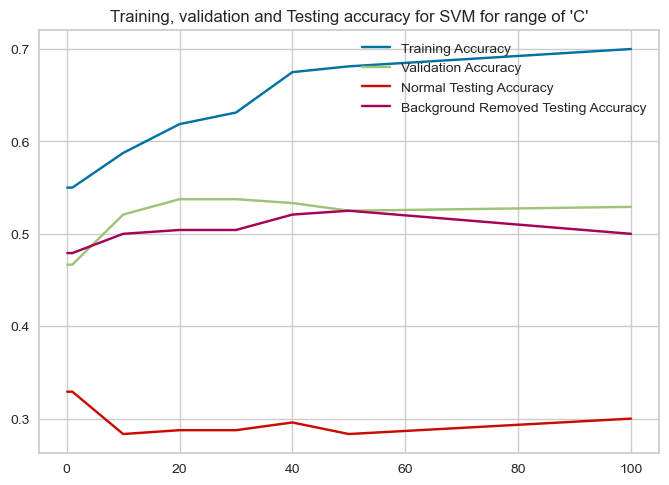

In [54]:
# Plot the results
plt.plot(C, training_accuracies, label='Training Accuracy')
plt.plot(C, validation_accuracies, label='Validation Accuracy')
plt.plot(C, testing_accuracies, label='Normal Testing Accuracy')
plt.plot(C, testing_accuracies_bg_rm, label='Background Removed Testing Accuracy')
plt.legend()
plt.title("Training, validation and Testing accuracy for SVM for range of 'C'")
plt.show()

The best value of C is 0.1 for testing data with an accuracy of 40.42%


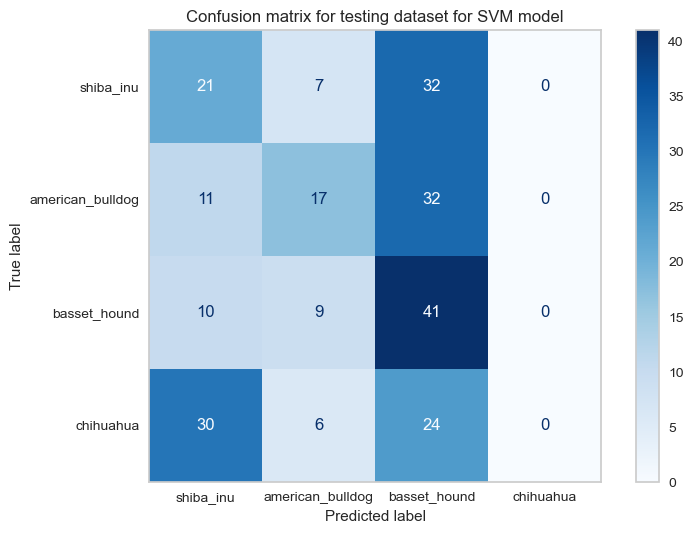

In [55]:
# best C for normal testing data
best_c = C[np.argmax(testing_accuracies)]
best_test_acc = max(testing_accuracies)
print(f"The best value of C is {best_c} for testing data with an accuracy of {best_val_acc:.2%}")
# C = best_c SVM classification
svm_classifier = svm.SVC(C = best_c, kernel = 'linear')
svm_classifier.fit(training_word_histograms, training_breed_labels)
# Testing on test data using best C hyperparameter
predicted_breed_labels = svm_classifier.predict(testing_word_histograms)
# Generating a confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Blues) # use a blue color map
plt.title('Confusion matrix for testing dataset for SVM model')
plt.tight_layout()
plt.grid(False)
plt.show()

The best value of C is 50 for testing data with an accuracy of 40.42%


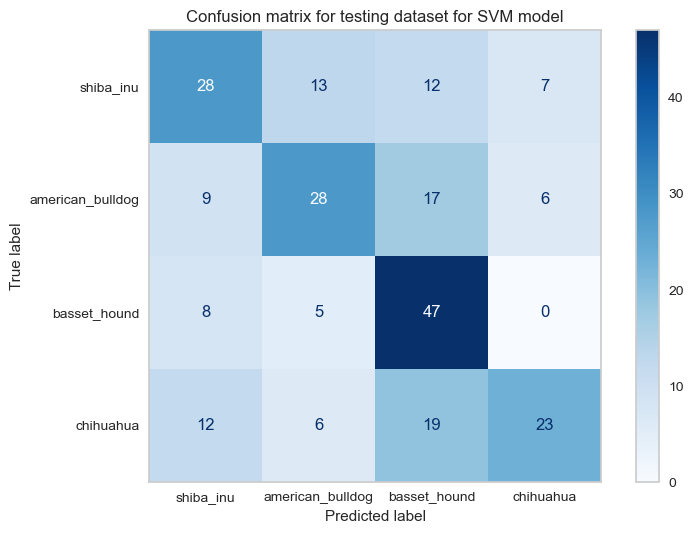

In [56]:
# best C for background removed testing data
best_c = C[np.argmax(testing_accuracies_bg_rm)]
best_test_acc = max(testing_accuracies_bg_rm)
print(f"The best value of C is {best_c} for testing data with an accuracy of {best_val_acc:.2%}")
# C = best_c SVM classification
svm_classifier_bg_rm = svm.SVC(C = best_c, kernel = 'linear')
svm_classifier_bg_rm.fit(training_word_histograms, training_breed_labels)
# Testing on test data using best C hyperparameter
predicted_breed_labels_bg_rm = svm_classifier_bg_rm.predict(testing_word_histograms_bg_rm)
# Generating a confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels_bg_rm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Blues) # use a blue color map
plt.title('Confusion matrix for testing dataset for SVM model')
plt.tight_layout()
plt.grid(False)
plt.show()

### Adaboost

In [57]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
testing_accuracies = []
testing_accuracies_bg_rm = []
n_estimator_range = [50, 100, 150, 200, 250]

In [58]:
for n_estimator in n_estimator_range:
    # Adaboost classifier
    adb_classifier = AdaBoostClassifier(n_estimators = n_estimator, random_state = 0)
    adb_classifier.fit(training_word_histograms, training_breed_labels)
    
    # Get accuracy on training dataset
    training_pred = adb_classifier.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)

    # Get accuracy on validation dataset
    validation_pred = adb_classifier.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

    # Get accuracy on testing dataset
    testing_pred = adb_classifier.predict(testing_word_histograms)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred)
    testing_accuracies.append(testing_acc)

    # Get accuracy on background removed testing dataset
    testing_pred_bg_rm = adb_classifier.predict(testing_word_histograms_bg_rm)
    testing_acc = accuracy_score(testing_breed_labels, testing_pred_bg_rm)
    testing_accuracies_bg_rm.append(testing_acc)

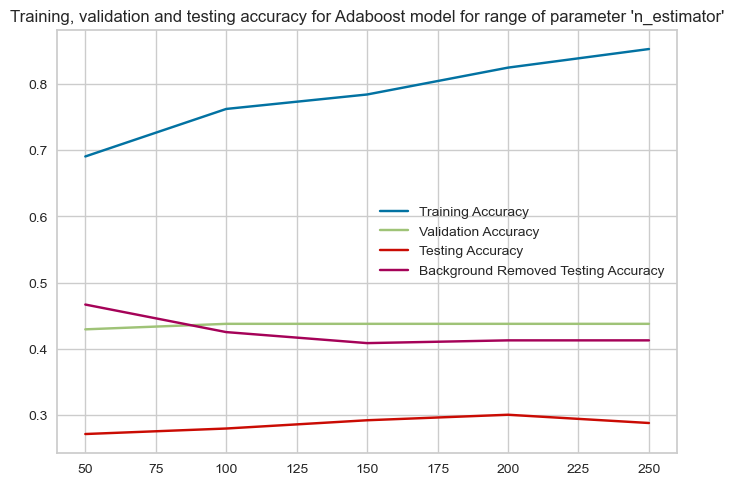

In [59]:
# Plot the results
plt.plot(n_estimator_range, training_accuracies, label='Training Accuracy')
plt.plot(n_estimator_range, validation_accuracies, label='Validation Accuracy')
plt.plot(n_estimator_range, testing_accuracies, label='Testing Accuracy')
plt.plot(n_estimator_range, testing_accuracies_bg_rm, label='Background Removed Testing Accuracy')
plt.legend()
plt.title("Training, validation and testing accuracy for Adaboost model for range of parameter 'n_estimator'")
plt.show()

The best value of n-estimators is 200 for testing data with an accuracy of 40.42%


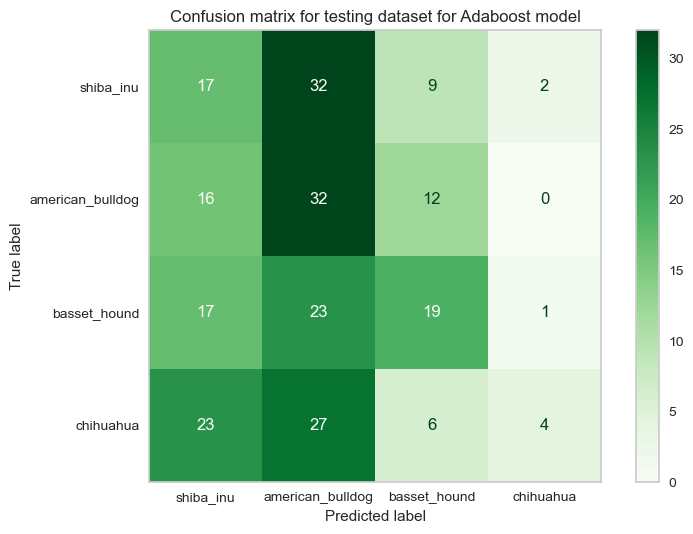

In [60]:
# best n_estimators for normal testing data
best_n = n_estimator_range[np.argmax(testing_accuracies)]
best_test_acc = max(testing_accuracies)
print(f"The best value of n-estimators is {best_n} for testing data with an accuracy of {best_val_acc:.2%}")
# Training on best parameters
adb_classifier = AdaBoostClassifier(n_estimators = best_n, random_state = 0)
adb_classifier.fit(training_word_histograms, training_breed_labels)
# Testing on best parameters using Test data
predicted_breed_labels = adb_classifier.predict(testing_word_histograms)
# Confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Greens) # use a blue color map
plt.title('Confusion matrix for testing dataset for Adaboost model')
plt.tight_layout()
plt.grid(False)
plt.show()

The best value of n-estimators is 50 for testing data with an accuracy of 40.42%


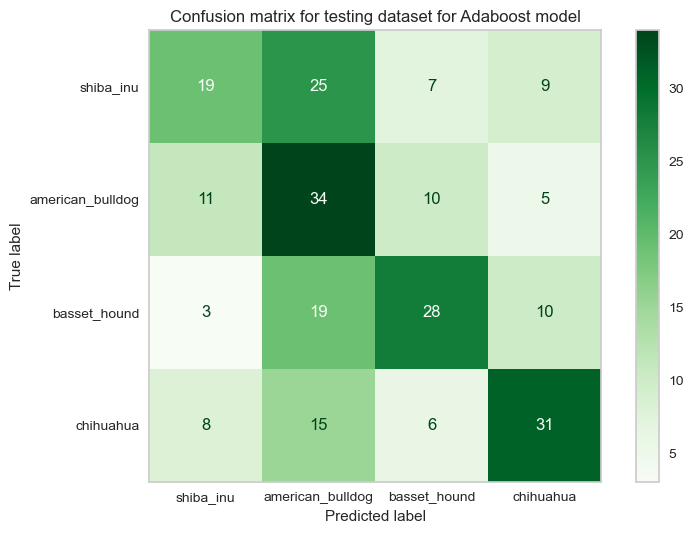

In [61]:
# best n_estimators for background removed testing data
best_n = n_estimator_range[np.argmax(testing_accuracies_bg_rm)]
best_test_acc = max(testing_accuracies_bg_rm)
print(f"The best value of n-estimators is {best_n} for testing data with an accuracy of {best_val_acc:.2%}")
# Training on best parameters
adb_classifier_bg_rm = AdaBoostClassifier(n_estimators = best_n, random_state = 0)
adb_classifier_bg_rm.fit(training_word_histograms, training_breed_labels)
# Testing on best parameters using Test data
predicted_breed_labels_bg_rm = adb_classifier_bg_rm.predict(testing_word_histograms_bg_rm)
# Confusion matrix
cm = confusion_matrix(testing_breed_labels, predicted_breed_labels_bg_rm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=breeds)
disp.plot(cmap=plt.cm.Greens) # use a blue color map
plt.title('Confusion matrix for testing dataset for Adaboost model')
plt.tight_layout()
plt.grid(False)
plt.show()

### K-NN

In [62]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
nn_search_space = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80]

In [63]:
# Train the knn model

for n_neighbours in nn_search_space:
    knn_bg_rm = KNeighborsClassifier(n_neighbors = n_neighbours)
    knn_bg_rm.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on training dataset
    training_pred = knn_bg_rm.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)
    
    # Get accuracy on validation dataset
    validation_pred = knn_bg_rm.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

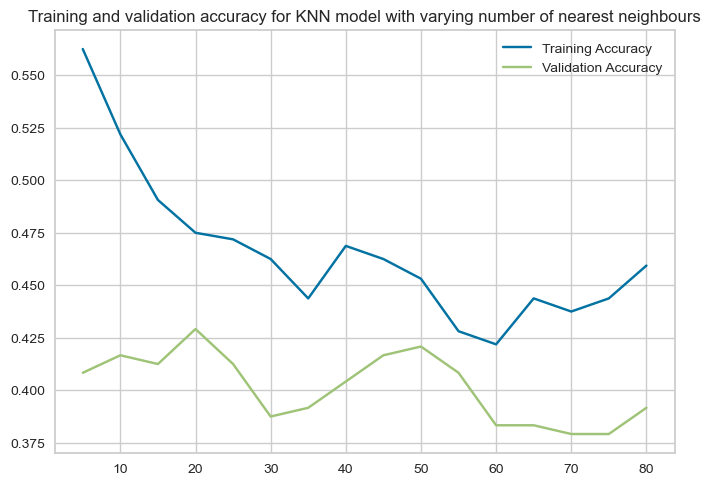

In [64]:
# Plot the results

plt.plot(nn_search_space, training_accuracies, label='Training Accuracy')
plt.plot(nn_search_space, validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Training and validation accuracy for KNN model with varying number of nearest neighbours")
plt.show()

In [65]:
best_nn = nn_search_space[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The value for number of nearest neighbour with the best validation accuracy is {best_nn} with an accuracy of {best_val_acc:.2%}")

The value for number of nearest neighbour with the best validation accuracy is 20 with an accuracy of 42.92%


In [66]:
# Re-train and save best model
knn_bg_rm = KNeighborsClassifier(n_neighbors = best_nn)
knn_bg_rm.fit(training_word_histograms, training_breed_labels)
with open('best_knn_bg_rm.pkl', 'wb') as f: #'wb' is for binary write
    pickle.dump(knn_bg_rm, f)

### Random Forest

In [67]:
# Define the training parameters
training_accuracies = []
validation_accuracies = []
n_estimators_search_space = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

In [68]:
# Train the rf model

for n_estimators in n_estimators_search_space:
    rf_bg_rm = RandomForestClassifier(n_estimators= n_neighbours)
    rf_bg_rm.fit(training_word_histograms, training_breed_labels)

    # Get accuracy on training dataset
    training_pred = rf_bg_rm.predict(training_word_histograms)
    training_acc = accuracy_score(training_breed_labels, training_pred)
    training_accuracies.append(training_acc)
    
    # Get accuracy on validation dataset
    validation_pred = rf_bg_rm.predict(validation_word_histograms)
    validation_acc = accuracy_score(validation_breed_labels, validation_pred)
    validation_accuracies.append(validation_acc)

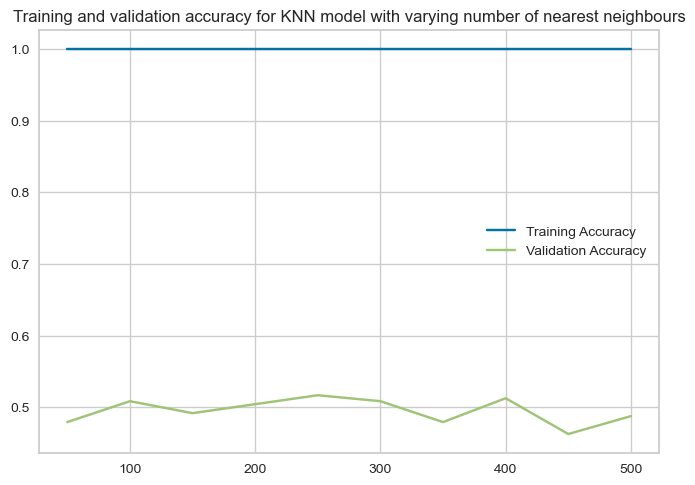

In [69]:
# Plot the results

plt.plot(n_estimators_search_space, training_accuracies, label='Training Accuracy')
plt.plot(n_estimators_search_space, validation_accuracies, label='Validation Accuracy')
plt.legend()
plt.title("Training and validation accuracy for KNN model with varying number of nearest neighbours")
plt.show()

In [70]:
best_n_estimators = n_estimators_search_space[np.argmax(validation_accuracies)]
best_val_acc = max(validation_accuracies)
print(f"The value for number of estimators with the best validation accuracy is {best_n_estimators} with an accuracy of {best_val_acc:.2%}")

The value for number of estimators with the best validation accuracy is 250 with an accuracy of 51.67%


In [71]:
# Re-train and save best model
rf_bg_rm = RandomForestClassifier(n_estimators= best_n_estimators)
rf_bg_rm.fit(training_word_histograms, training_breed_labels)
with open('best_rf_bg_rm.pkl', 'wb') as f: #'wb' is for binary write
    pickle.dump(rf_bg_rm, f)

## 2.3 Evaluating classifiers after removing background

The accuracy on the unmodified test dataset for the SVM model trained on unmodified images is 32.92%
The accuracy on the unmodified test dataset for the SVM model trained on background removed images is 28.33%
The accuracy on the background removed test dataset for the SVM model trained on background removed images is 52.50%


The accuracy on the unmodified test dataset for the Adaboost model trained on unmodified images is 30.00%
The accuracy on the unmodified test dataset for the Adaboost model trained on background removed images is 27.08%
The accuracy on the background removed test dataset for the Adaboost model trained on background removed images is 46.67%


The accuracy on the unmodified test dataset for the KNN model trained on unmodified images is 25.83%
The accuracy on the unmodified test dataset for the KNN model trained on background removed images is 23.75%
The accuracy on the background removed test dataset for the KNN model trained on background removed images is 38.75%


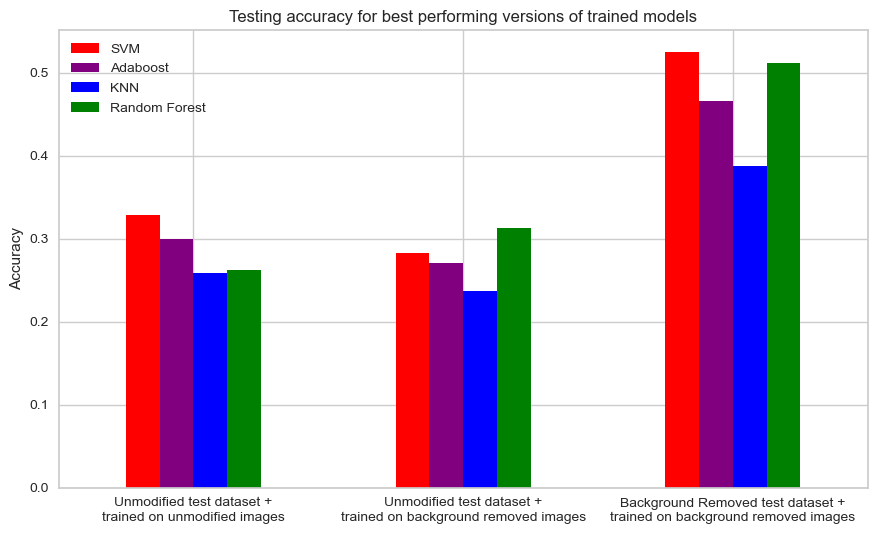

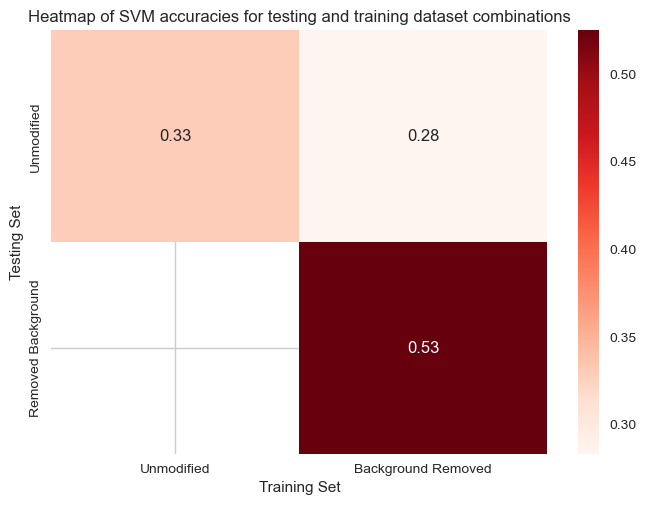

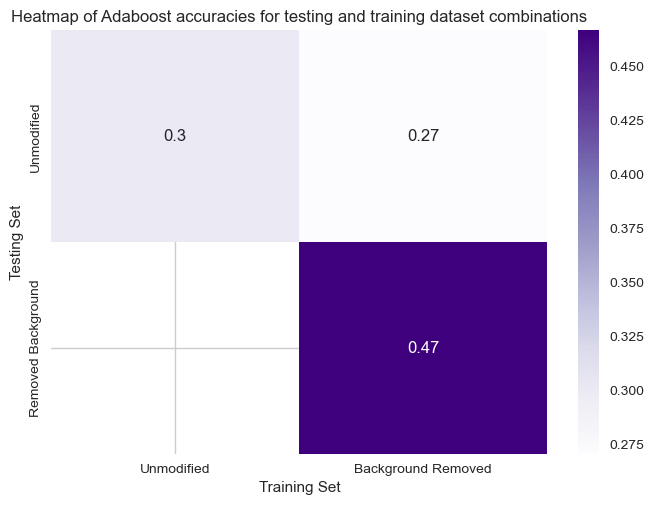

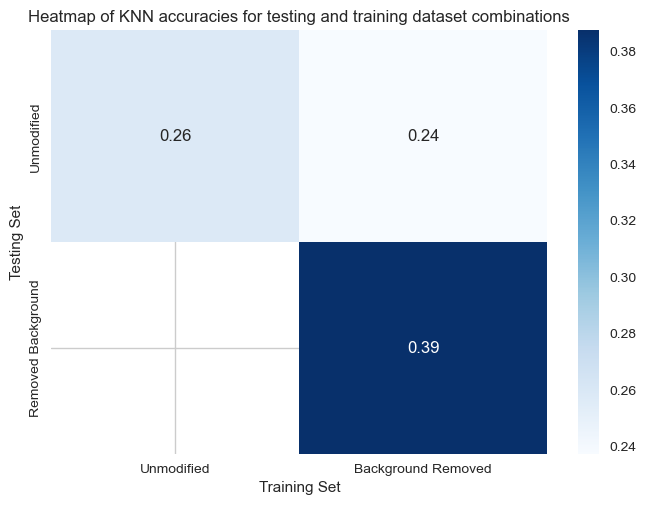

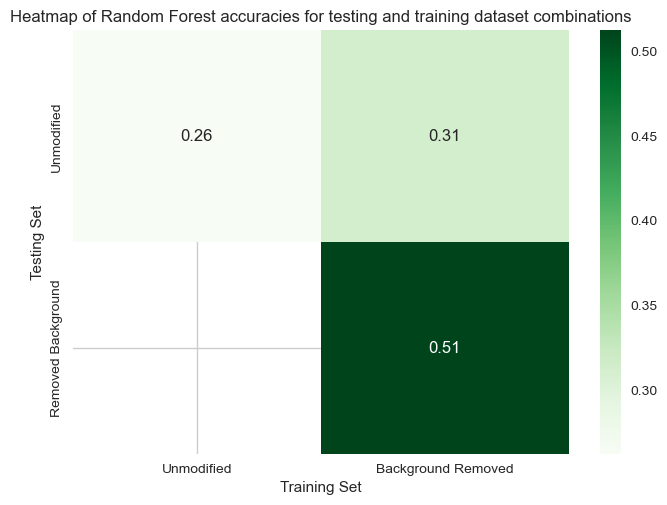

In [80]:
svm_predicted_labels = svm_classifier.predict(testing_word_histograms)
adb_predicted_labels = adb_classifier.predict(testing_word_histograms)
knn_predicted_labels = knn.predict(testing_word_histograms)
rf_predicted_labels = rf.predict(testing_word_histograms)
svm_predicted_labels_no_mod = svm_classifier_bg_rm.predict(testing_word_histograms)
adb_predicted_labels_no_mod = adb_classifier_bg_rm.predict(testing_word_histograms)
knn_predicted_labels_no_mod = knn_bg_rm.predict(testing_word_histograms)
rf_predicted_labels_no_mod = rf_bg_rm.predict(testing_word_histograms)
svm_predicted_labels_bg_rm = svm_classifier_bg_rm.predict(testing_word_histograms_bg_rm)
adb_predicted_labels_bg_rm = adb_classifier_bg_rm.predict(testing_word_histograms_bg_rm)
knn_predicted_labels_bg_rm = knn_bg_rm.predict(testing_word_histograms_bg_rm)
rf_predicted_labels_bg_rm = rf_bg_rm.predict(testing_word_histograms_bg_rm)

svm_test_acc = accuracy_score(testing_breed_labels, svm_predicted_labels)
svm_test_acc_no_mod = accuracy_score(testing_breed_labels, svm_predicted_labels_no_mod)
svm_test_acc_bg_rm = accuracy_score(testing_breed_labels, svm_predicted_labels_bg_rm)
print(f"The accuracy on the unmodified test dataset for the SVM model trained on unmodified images is {svm_test_acc:.2%}")
print(f"The accuracy on the unmodified test dataset for the SVM model trained on background removed images is {svm_test_acc_no_mod:.2%}")
print(f"The accuracy on the background removed test dataset for the SVM model trained on background removed images is {svm_test_acc_bg_rm:.2%}")
print('\n')

adb_test_acc = accuracy_score(testing_breed_labels, adb_predicted_labels)
adb_test_acc_no_mod = accuracy_score(testing_breed_labels, adb_predicted_labels_no_mod)
adb_test_acc_bg_rm = accuracy_score(testing_breed_labels, adb_predicted_labels_bg_rm)
print(f"The accuracy on the unmodified test dataset for the Adaboost model trained on unmodified images is {adb_test_acc:.2%}")
print(f"The accuracy on the unmodified test dataset for the Adaboost model trained on background removed images is {adb_test_acc_no_mod:.2%}")
print(f"The accuracy on the background removed test dataset for the Adaboost model trained on background removed images is {adb_test_acc_bg_rm:.2%}")
print('\n')

knn_test_acc = accuracy_score(testing_breed_labels, knn_predicted_labels)
knn_test_acc_no_mod = accuracy_score(testing_breed_labels, knn_predicted_labels_no_mod)
knn_test_acc_bg_rm = accuracy_score(testing_breed_labels, knn_predicted_labels_bg_rm)
print(f"The accuracy on the unmodified test dataset for the KNN model trained on unmodified images is {knn_test_acc:.2%}")
print(f"The accuracy on the unmodified test dataset for the KNN model trained on background removed images is {knn_test_acc_no_mod:.2%}")
print(f"The accuracy on the background removed test dataset for the KNN model trained on background removed images is {knn_test_acc_bg_rm:.2%}")
print('\n')

rf_test_acc = accuracy_score(testing_breed_labels, rf_predicted_labels)
rf_test_acc_no_mod = accuracy_score(testing_breed_labels, rf_predicted_labels_no_mod)
rf_test_acc_bg_rm = accuracy_score(testing_breed_labels, rf_predicted_labels_bg_rm)
print(f"The accuracy on the unmodified test dataset for the Random Forest model trained on unmodified images is {rf_test_acc:.2%}")
print(f"The accuracy on the unmodified test dataset for the Random Forest model trained on background removed images is {rf_test_acc_no_mod:.2%}")
print(f"The accuracy on the background removed test dataset for the Random Forest model trained on background removed images is {rf_test_acc_bg_rm:.2%}")


measurements = [
    "Unmodified test dataset +\ntrained on unmodified images",
    "Unmodified test dataset +\ntrained on background removed images",
    "Background Removed test dataset +\ntrained on background removed images"
    ]
accuracies = {
    "SVM" : [svm_test_acc, svm_test_acc_no_mod, svm_test_acc_bg_rm],
    "Adaboost" : [adb_test_acc, adb_test_acc_no_mod, adb_test_acc_bg_rm],
    "KNN" : [knn_test_acc, knn_test_acc_no_mod, knn_test_acc_bg_rm],
    "Random Forest" : [rf_test_acc, rf_test_acc_no_mod, rf_test_acc_bg_rm]
}

accuracies_df = pd.DataFrame(accuracies, index=measurements)

colours = ['red', 'purple', 'blue', 'green']

# Plot results
accuracies_df.plot(kind='bar', color=colours)
plt.ylabel('Accuracy')
plt.xticks(rotation=0)
plt.title('Testing accuracy for best performing versions of trained models')
plt.gcf().set_figwidth(9)
plt.tight_layout()
plt.show()

# Create a heatmap visuals
svm_heatmap_df = pd.DataFrame(
    {"Unmodified": [svm_test_acc, np.nan], "Background Removed": [svm_test_acc_no_mod, svm_test_acc_bg_rm] },
    index = ["Unmodified", "Removed Background"]
)
svm_heatmap = sns.heatmap(svm_heatmap_df, cmap="Reds", annot=True)
svm_heatmap.set_xlabel("Training Set")
svm_heatmap.set_ylabel("Testing Set")
svm_heatmap.set_title("Heatmap of SVM accuracies for testing and training dataset combinations")
plt.show()

adb_heatmap_df = pd.DataFrame(
    {"Unmodified": [adb_test_acc, np.nan], "Background Removed": [adb_test_acc_no_mod, adb_test_acc_bg_rm] },
    index = ["Unmodified", "Removed Background"]
)
adb_heatmap = sns.heatmap(adb_heatmap_df, cmap="Purples", annot=True)
adb_heatmap.set_xlabel("Training Set")
adb_heatmap.set_ylabel("Testing Set")
adb_heatmap.set_title("Heatmap of Adaboost accuracies for testing and training dataset combinations")
plt.show()


knn_heatmap_df = pd.DataFrame(
    {"Unmodified": [knn_test_acc, np.nan], "Background Removed": [knn_test_acc_no_mod, knn_test_acc_bg_rm] },
    index = ["Unmodified", "Removed Background"]
)
knn_heatmap = sns.heatmap(knn_heatmap_df, cmap="Blues", annot=True)
knn_heatmap.set_xlabel("Training Set")
knn_heatmap.set_ylabel("Testing Set")
knn_heatmap.set_title("Heatmap of KNN accuracies for testing and training dataset combinations")
plt.show()

rf_heatmap_df = pd.DataFrame(
    {"Unmodified": [rf_test_acc, np.nan], "Background Removed": [rf_test_acc_no_mod, rf_test_acc_bg_rm] },
    index = ["Unmodified", "Removed Background"]
)
rf_heatmap = sns.heatmap(rf_heatmap_df, cmap="Greens", annot=True)
rf_heatmap.set_xlabel("Training Set")
rf_heatmap.set_ylabel("Testing Set")
rf_heatmap.set_title("Heatmap of Random Forest accuracies for testing and training dataset combinations")
plt.show()

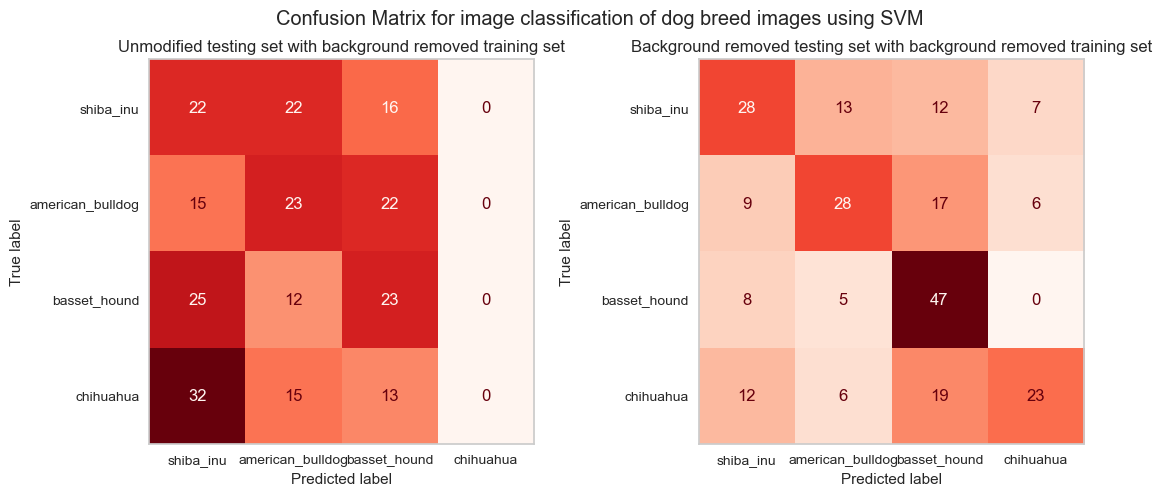

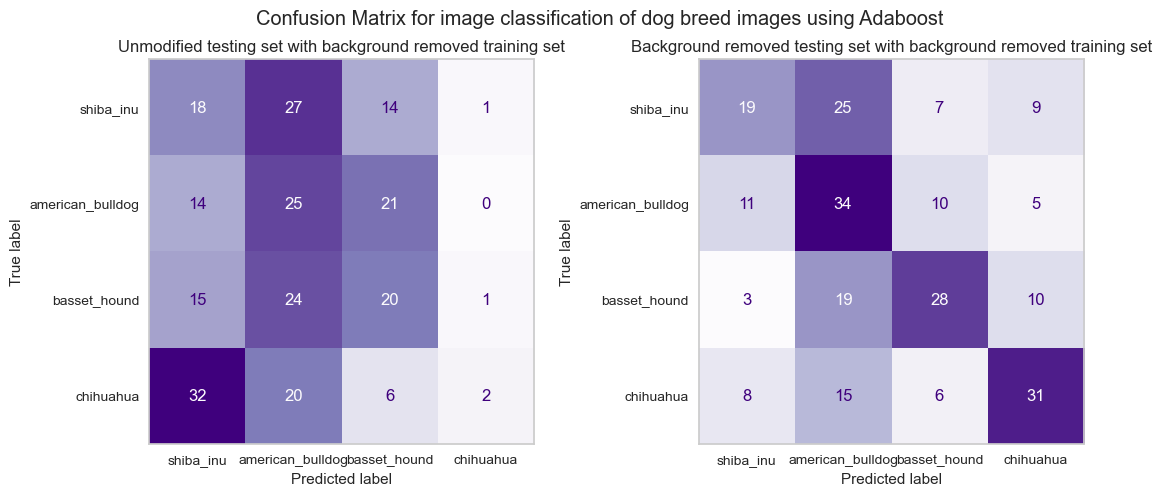

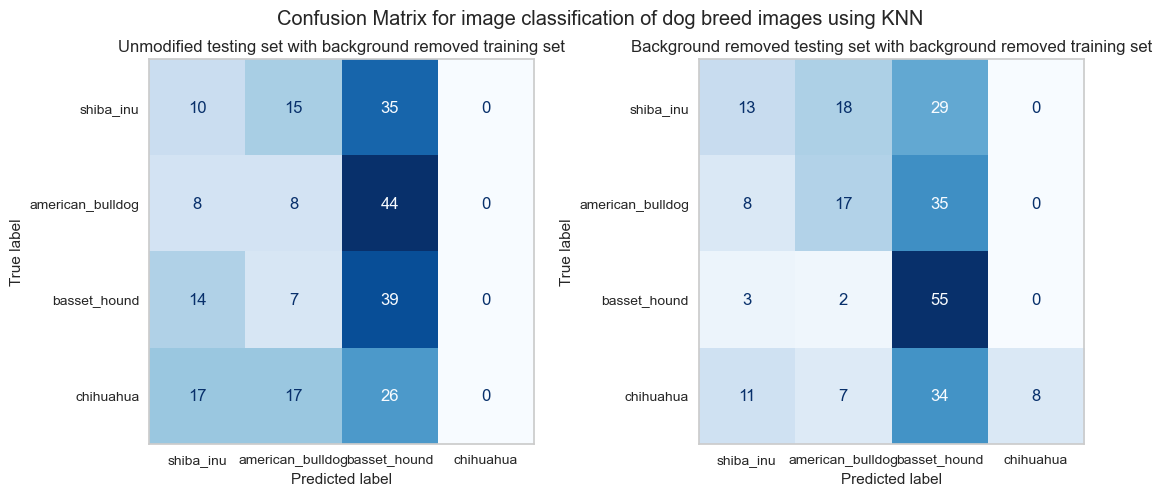

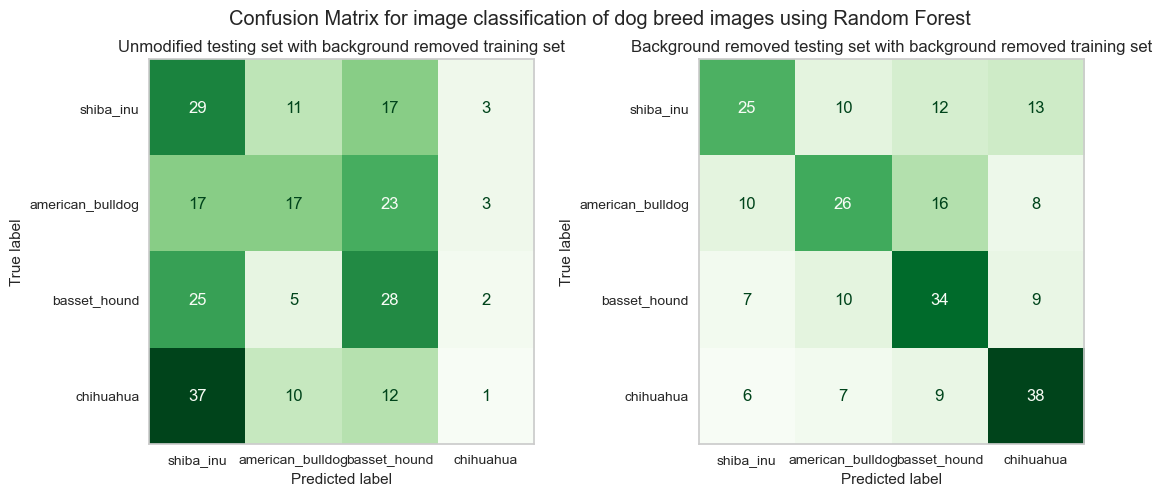

In [82]:
# Plot confusion matrices
fig, axes = plt.subplots(1,2)
fig.set_size_inches(13,5)
svm_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, svm_predicted_labels_no_mod, display_labels=breeds, cmap="Reds", ax=axes[0], colorbar=False)
svm_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, svm_predicted_labels_bg_rm, display_labels=breeds, cmap="Reds", ax=axes[1], colorbar=False)
axes[0].set_title("Unmodified testing set with background removed training set")
axes[1].set_title("Background removed testing set with background removed training set")
axes[0].grid(False)
axes[1].grid(False)
fig.suptitle("Confusion Matrix for image classification of dog breed images using SVM")
plt.show()

fig, axes = plt.subplots(1,2)
fig.set_size_inches(13,5)
adb_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, adb_predicted_labels_no_mod, display_labels=breeds, cmap="Purples", ax=axes[0], colorbar=False)
adb_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, adb_predicted_labels_bg_rm, display_labels=breeds, cmap="Purples", ax=axes[1], colorbar=False)
axes[0].set_title("Unmodified testing set with background removed training set")
axes[1].set_title("Background removed testing set with background removed training set")
axes[0].grid(False)
axes[1].grid(False)
fig.suptitle("Confusion Matrix for image classification of dog breed images using Adaboost")
plt.show()

fig, axes = plt.subplots(1,2)
fig.set_size_inches(13,5)
knn_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, knn_predicted_labels_no_mod, display_labels=breeds, cmap="Blues", ax=axes[0], colorbar=False)
knn_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, knn_predicted_labels_bg_rm, display_labels=breeds, cmap="Blues", ax=axes[1], colorbar=False)
axes[0].set_title("Unmodified testing set with background removed training set")
axes[1].set_title("Background removed testing set with background removed training set")
axes[0].grid(False)
axes[1].grid(False)
fig.suptitle("Confusion Matrix for image classification of dog breed images using KNN")
plt.show()

fig, axes = plt.subplots(1,2)
fig.set_size_inches(13,5)
rf_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, rf_predicted_labels_no_mod, display_labels=breeds, cmap="Greens", ax=axes[0], colorbar=False)
rf_cf_disp = ConfusionMatrixDisplay.from_predictions(testing_breed_labels, rf_predicted_labels_bg_rm, display_labels=breeds, cmap="Greens", ax=axes[1], colorbar=False)
axes[0].set_title("Unmodified testing set with background removed training set")
axes[1].set_title("Background removed testing set with background removed training set")
axes[0].grid(False)
axes[1].grid(False)
fig.suptitle("Confusion Matrix for image classification of dog breed images using Random Forest")
plt.show()